In [42]:
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import numpy as np
import xgboost
print("Versions des bibliothèques :")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"XGBoost: {xgboost.__version__}")
print(f"Numpy: {np.__version__}")

Versions des bibliothèques :
Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Pandas: 2.3.3
Scikit-Learn: 1.8.0
Matplotlib: 3.10.8
Seaborn: 0.13.2
XGBoost: 3.1.2
Numpy: 2.3.5


# Projet : Analyse de l'Insertion des Diplômés de Master

## 1 Choix et comprehension du dataset

1. Présentation du Dataset Dans le cadre du module AAS, nous analysons le jeu de données "Insertion professionnelle des diplômés de Master" (source : data.gouv.fr). Ce dataset recense les indicateurs d'emploi (taux d'insertion, salaires) des diplômés universitaires en France, agrégés par établissement, discipline et année.

2. Objectif et Tâche ML L'objectif est d'identifier les facteurs déterminants de l'employabilité des jeunes diplômés.

Nous formulons ce problème comme une tâche de Régression :

Variable Cible (Target) : taux_dinsertion (le pourcentage de diplômés ayant un emploi) ET salaire_net_median_des_emplois_a_temps_plein.

Démarche : Le projet suivra un pipeline complet : nettoyage des données, exploration visuelle (EDA) et modélisation prédictive.

On va supprimer toutes les lignes ou le taux d'insertions n'est pas donner 

# 2.Nettoyage

## 2.1 importations du dataset

In [43]:
import numpy as np
import pandas as pd
df = pd.read_csv('fr-esr-insertion_professionnelle-master.csv', sep=';')
df.head()

,annee,diplome,numero_de_l_etablissement,etablissement,etablissementactuel,code_de_l_academie,academie,code_du_domaine,domaine,code_de_la_discipline,...,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile,cle_etab,cle_disc,id_paysage
0,2012,MASTER LMD,0681166Y,Mulhouse - Haute Alsace,NaN,A15,Strasbourg,STS,"Sciences, technologies et santé",disc15,...,9.3,1760,ns,ns,ns,1430,2080,Mulhouse - Haute Alsace_18,disc15_18,OJZ4a
1,2012,MASTER LMD,0691775E,Lyon 2 - Lumière,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc09,...,8.9,1780,81,29,83,1430,2130,Lyon 2 - Lumière_18,disc09_18,CUBKB
2,2012,MASTER LMD,0692437Z,Lyon 3 - Jean Moulin,NaN,A10,Lyon,SHS,Sciences humaines et sociales,disc11,...,8.9,1780,45,41,57,1430,2130,Lyon 3 - Jean Moulin_18,disc11_18,7Gzub
3,2012,MASTER LMD,0730858L,Savoie Mont Blanc,NaN,A08,Grenoble,DEG,"Droit, économie et gestion",disc01,...,8.9,1780,30,46,66,1430,2130,Savoie Mont Blanc_18,disc01_18,zCa4j
4,2012,MASTER LMD,0750736T,Paris - Dauphine,NaN,A01,Paris,DEG,"Droit, économie et gestion",disc04,...,9,2020,NaN,NaN,NaN,1580,2530,Paris - Dauphine_18,disc04_18,C6Ps7


In [44]:
# 1. Nettoyage intelligent et Vérification
# Liste des colonnes à supprimer si elles existent (identifiants et codes redondants pour éviter l'overfitting)
colonnes_a_supprimer = [
    'numero_de_l_etablissement', 'id_paysage', 'cle_etab', 'cle_disc',
    'code_de_l_academie', 'code_du_domaine', 'code_de_la_discipline',
    'etablissementactuel', 'diplome',
]

# Vérifier et supprimer les colonnes existantes
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df.columns]
if colonnes_existantes:
    df = df.drop(columns=colonnes_existantes)
    print(f"Colonnes supprimées pour éviter l'overfitting : {colonnes_existantes}")
else:
    print("Aucune des colonnes spécifiées n'existe dans le DataFrame.")

# Afficher les colonnes restantes pour vérification
print(f"Colonnes restantes après nettoyage : {list(df.columns)}")

Colonnes supprimées pour éviter l'overfitting : ['numero_de_l_etablissement', 'id_paysage', 'cle_etab', 'cle_disc', 'code_de_l_academie', 'code_du_domaine', 'code_de_la_discipline', 'etablissementactuel', 'diplome']
Colonnes restantes après nettoyage : ['annee', 'etablissement', 'academie', 'domaine', 'discipline', 'situation', 'remarque', 'nombre_de_reponses', 'taux_de_reponse', 'poids_de_la_discipline', 'taux_dinsertion', 'taux_d_emploi', 'taux_d_emploi_salarie_en_france', 'emplois_cadre_ou_professions_intermediaires', 'emplois_stables', 'emplois_a_temps_plein', 'salaire_net_median_des_emplois_a_temps_plein', 'salaire_brut_annuel_estime', 'de_diplomes_boursiers', 'taux_de_chomage_regional', 'salaire_net_mensuel_median_regional', 'emplois_cadre', 'emplois_exterieurs_a_la_region_de_luniversite', 'femmes', 'salaire_net_mensuel_regional_1er_quartile', 'salaire_net_mensuel_regional_3eme_quartile']


## 2.2 SUPPRESSION DES NS.
On supprime les ns par la moyenne trouver qui correspond a la discipline sciences de l'ingenieur et les ns qui correspondes au emplois_cadre_ou_professions_intermediaires.

In [45]:
df_clean = df.copy()
# Liste des valeurs considérées comme manquantes
missing_vals = ["ns", "nd", "", " "]

# Identifier les colonnes numériques potentielles (celles qui devraient être numériques)
colonnes_numeriques = [
    "nombre_de_reponses", "taux_de_reponse", "poids_de_la_discipline", "taux_dinsertion",
    "emplois_cadre_ou_professions_intermediaires", "emplois_stables", "emplois_a_temps_plein",
    "salaire_net_median_des_emplois_a_temps_plein", "salaire_brut_annuel_estime",
    "de_diplomes_boursiers", "taux_de_chomage_regional", "salaire_net_mensuel_median_regional",
    "emplois_cadre", "emplois_exterieurs_a_la_region_de_luniversite", "femmes",
    "salaire_net_mensuel_regional_1er_quartile", "salaire_net_mensuel_regional_3eme_quartile",
    "annee"
]

# Convertir toutes les colonnes numériques, en remplaçant 'ns', 'nd' etc. par NaN
for col in colonnes_numeriques:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col].replace(missing_vals, pd.NA), errors="coerce")

# Supprimer uniquement les lignes où taux_dinsertion est manquant
df_clean = df_clean[df_clean["taux_dinsertion"].notna()]

# Imputation par médiane groupée par discipline pour les autres variables numériques
for col in colonnes_numeriques:
    if col in df_clean.columns and col != "taux_dinsertion":
        df_clean[col] = df_clean.groupby('discipline')[col].transform(lambda x: x.fillna(x.median()))

# Pour les groupes sans médiane (tous NaN), imputer par médiane globale
for col in colonnes_numeriques:
    if col in df_clean.columns and col != "taux_dinsertion":
        global_median = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(global_median)

C:\Users\mmath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mmath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mmath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\mmath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarnin

## 2.3 On supprime les lignes qui contiennent au moins 1/3 de NaN

## 2.4 On utilises une methode qu'on appele IQR pour detecter les outliers(si x < Q1 - 5*IQR ou x > Q3 + 5*IQR)



In [46]:
# Liste des colonnes numériques pour le traitement des outliers
colonnes_numeriques = [
    "nombre_de_reponses", "taux_de_reponse", "poids_de_la_discipline", "taux_dinsertion",
    "emplois_cadre_ou_professions_intermediaires", "emplois_stables", "emplois_a_temps_plein",
    "salaire_net_median_des_emplois_a_temps_plein", "salaire_brut_annuel_estime",
    "de_diplomes_boursiers", "taux_de_chomage_regional", "salaire_net_mensuel_median_regional",
    "emplois_cadre", "emplois_exterieurs_a_la_region_de_luniversite", "femmes",
    "salaire_net_mensuel_regional_1er_quartile", "salaire_net_mensuel_regional_3eme_quartile",
    "annee"
]

# Appliquer la méthode IQR pour détecter et supprimer les outliers
for col in colonnes_numeriques:
    if col in df_clean.columns:
        # Calculer Q1, Q3, IQR
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Bornes pour les outliers (facteur 1.5 standard, mais ici 5 comme demandé)
        borne_basse = Q1 - 5 * IQR
        borne_haute = Q3 + 5 * IQR

        # Filtrer les données
        df_clean = df_clean[(df_clean[col] >= borne_basse) & (df_clean[col] <= borne_haute)]

print(f"Lignes après traitement des outliers : {len(df_clean)}")

Lignes après traitement des outliers : 10404


## 2.6 IMPUTATION DES VARIABLES EXPLICATIVES (FEATURES)
 Pour ne pas perdre d'info, on remplit les trous des autres colonnes numériques (ex: salaire) par la médiane

In [47]:
# 1. Liste des colonnes textuelles que nous voulons utiliser
# On encode seulement les variables d'orientation (discipline, academie, situation)
colonnes_texte = ['situation', 'discipline', 'academie']

# 2. Transformation avec la fonction get_dummies de Pandas (encodage des variables d'orientation)
df_final = pd.get_dummies(df_clean, columns=colonnes_texte, drop_first=True)

# 3. Définition des cibles (à exclure de X)
targets = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']

# 4. Exclure explicitement les colonnes qui sont des conséquences post-diplôme
drop_explicit = ['salaire_brut_annuel_estime']
# Mots-clés typiques indiquant des métriques post-diplôme/outcomes (insensibles à la casse)
outcome_keywords = ['salaire', 'brut', 'emploi', 'emplois', 'insertion', 'cadre', 'reponse', 'reponses']

# Construire la liste des colonnes à exclure de X (targets + explicites + colonnes contenant mots-clés)
cols_to_drop = set(targets + drop_explicit)
for c in df_final.columns:
    lc = c.lower()
    if any(k in lc for k in outcome_keywords):
        cols_to_drop.add(c)

# 5. Construire X : ne garder QUE les variables d'orientation (one-hot des colonnes choisies) et
#    quelques caractéristiques fixes du diplôme si présentes (ex: poids_de_la_discipline, annee, de_diplomes_boursiers)
orientation_prefixes = ['discipline_', 'academie_', 'situation_', 'type_d_etablissement_', 'etablissement_type_']
orientation_cols = [c for c in df_final.columns if any(c.startswith(pref) for pref in orientation_prefixes)]
fixed_numeric_candidates = ['poids_de_la_discipline', 'annee', 'de_diplomes_boursiers']
fixed_numeric = [c for c in fixed_numeric_candidates if c in df_final.columns and c not in cols_to_drop]

# Assembler X à partir des colonnes d'orientation + caractéristiques fixes si disponibles
X = pd.DataFrame(index=df_final.index)
if orientation_cols:
    X = pd.concat([X, df_final[orientation_cols]], axis=1)
if fixed_numeric:
    X = pd.concat([X, df_final[fixed_numeric]], axis=1)

# Si aucune colonne d'orientation n'a été trouvée (fallback sûr) : garder toutes les colonnes numériques
# sauf celles marquées comme outcomes/targets (cette situation est improbable mais sûre)
if X.shape[1] == 0:
    print('Avertissement : aucun dummy d\'orientation trouvé. Application d\'un fallback sécurisé pour X.')
    X = df_final.drop(columns=list(cols_to_drop), errors='ignore').select_dtypes(include=[np.number])

# 6. Définir y (targets) et afficher un résumé des colonnes gardées/supprimées
y = df_final[targets]  # Multi-output targets

kept = list(X.columns)
dropped = sorted(list(cols_to_drop & set(df_final.columns)))
print(f"Colonnes supprimées (exclues de X): {dropped}")
print(f"Colonnes conservées dans X: {kept}")
print(f"Dimension de X: {X.shape}, Dimension de y: {y.shape}")

Colonnes supprimées (exclues de X): ['emplois_a_temps_plein', 'emplois_cadre', 'emplois_cadre_ou_professions_intermediaires', 'emplois_exterieurs_a_la_region_de_luniversite', 'emplois_stables', 'nombre_de_reponses', 'salaire_brut_annuel_estime', 'salaire_net_median_des_emplois_a_temps_plein', 'salaire_net_mensuel_median_regional', 'salaire_net_mensuel_regional_1er_quartile', 'salaire_net_mensuel_regional_3eme_quartile', 'taux_d_emploi', 'taux_d_emploi_salarie_en_france', 'taux_de_reponse', 'taux_dinsertion']
Colonnes conservées dans X: ['situation_30 mois après le diplôme', 'discipline_Autres sciences humaines et sociales', 'discipline_Autres sciences, technologies et santé', 'discipline_Droit', 'discipline_Ensemble formations juridiques, économiques et de gestion', 'discipline_Ensemble sciences humaines et sociales', 'discipline_Ensemble sciences, technologies et santé', 'discipline_Gestion', 'discipline_Histoire-géographie', 'discipline_Information communication', 'discipline_Informa

In [48]:
# Vérification du Data Leakage
# Calculer la corrélation entre toutes les features numériques et les cibles
numeric_features = df_final.select_dtypes(include=[np.number]).drop(columns=targets).columns
correlations = df_final[numeric_features].corrwith(df_final['taux_dinsertion']).abs()
correlations_salaire = df_final[numeric_features].corrwith(df_final['salaire_net_median_des_emplois_a_temps_plein']).abs()

# Identifier les features avec corrélation > 0.9 avec au moins une cible
leaky_features = correlations[correlations > 0.9].index.tolist() + correlations_salaire[correlations_salaire > 0.9].index.tolist()
leaky_features = list(set(leaky_features))  # Supprimer doublons

print(f"Features avec forte corrélation (>0.9) avec les cibles : {leaky_features}")

if leaky_features:
    print("Attention : Risque de data leakage. Suppression de ces features de X.")
    # Supprimer de X si elles existent
    for feat in leaky_features:
        if feat in X.columns:
            X = X.drop(columns=[feat])
            print(f"Colonne {feat} supprimée de X.")
else:
    print("Pas de forte corrélation détectée.")

Features avec forte corrélation (>0.9) avec les cibles : ['salaire_brut_annuel_estime']
Attention : Risque de data leakage. Suppression de ces features de X.


In [49]:
df_clean

,annee,etablissement,academie,domaine,discipline,situation,remarque,nombre_de_reponses,taux_de_reponse,poids_de_la_discipline,...,salaire_net_median_des_emplois_a_temps_plein,salaire_brut_annuel_estime,de_diplomes_boursiers,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile
2,2012,Lyon 3 - Jean Moulin,Lyon,Sciences humaines et sociales,Autres sciences humaines et sociales,18 mois après le diplôme,NaN,46.0,81.0,6.0,...,1700.0,26500.0,25.0,8.9,1780.0,45.0,41.0,57.0,1430.0,2130.0
3,2012,Savoie Mont Blanc,Grenoble,"Droit, économie et gestion","Ensemble formations juridiques, économiques et...",18 mois après le diplôme,NaN,244.0,85.0,56.0,...,1760.0,27400.0,33.0,8.9,1780.0,30.0,46.0,66.0,1430.0,2130.0
5,2012,Paris 1 - Panthéon Sorbonne,Paris,"Sciences, technologies et santé","Ensemble sciences, technologies et santé",30 mois après le diplôme,NaN,30.0,61.0,4.0,...,2000.0,31200.0,18.0,9.0,2020.0,72.0,49.0,38.0,1580.0,2530.0
10,2012,Toulon,Nice,"Droit, économie et gestion","Ensemble formations juridiques, économiques et...",18 mois après le diplôme,NaN,77.0,73.0,43.0,...,1530.0,23800.0,40.0,11.7,1790.0,21.0,23.0,74.0,1390.0,2170.0
14,2012,Poitiers,Poitiers,"Sciences, technologies et santé",Sciences de la vie et de la terre,18 mois après le diplôme,Université dont les résultats sont plus fragil...,61.0,63.0,8.0,...,1820.0,28300.0,39.0,9.6,1820.0,66.0,84.0,60.0,1380.0,1980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19595,2015,Paris 7 - Denis Diderot,Paris,"Lettres, langues, arts","Lettres, langues, arts",30 mois après le diplôme,NaN,65.0,57.0,27.0,...,2000.0,31200.0,21.0,7.8,2060.0,67.0,22.0,71.0,1600.0,2570.0
19597,2015,Poitiers,Poitiers,"Sciences, technologies et santé","Autres sciences, technologies et santé",18 mois après le diplôme,NaN,32.0,61.0,7.0,...,1855.0,29100.0,39.0,8.4,1750.0,56.0,64.0,18.0,1390.0,2060.0
19599,2015,Évry-Val d'Essonne,Versailles,"Sciences, technologies et santé",Sciences de l'ingénieur,30 mois après le diplôme,NaN,69.0,73.0,21.0,...,2300.0,35900.0,22.0,7.8,2060.0,72.0,23.0,30.0,1600.0,2570.0
19601,2015,Université Sorbonne Paris Nord,Créteil,Sciences humaines et sociales,Ensemble sciences humaines et sociales,30 mois après le diplôme,Université dont les résultats sont plus fragil...,110.0,48.0,44.0,...,1800.0,28100.0,36.0,7.8,2060.0,60.0,29.0,82.0,1600.0,2570.0


## 2.8 Resultat

In [50]:
print(f"Lignes avant : {len(df)} -> Lignes après nettoyage : {len(df_clean)}")
df_clean.head()
df_clean.to_csv("fr-esr-cleaned.csv", sep=";", index=False)
df_clean.head()

Lignes avant : 19603 -> Lignes après nettoyage : 10404


,annee,etablissement,academie,domaine,discipline,situation,remarque,nombre_de_reponses,taux_de_reponse,poids_de_la_discipline,...,salaire_net_median_des_emplois_a_temps_plein,salaire_brut_annuel_estime,de_diplomes_boursiers,taux_de_chomage_regional,salaire_net_mensuel_median_regional,emplois_cadre,emplois_exterieurs_a_la_region_de_luniversite,femmes,salaire_net_mensuel_regional_1er_quartile,salaire_net_mensuel_regional_3eme_quartile
2,2012,Lyon 3 - Jean Moulin,Lyon,Sciences humaines et sociales,Autres sciences humaines et sociales,18 mois après le diplôme,NaN,46.0,81.0,6.0,...,1700.0,26500.0,25.0,8.9,1780.0,45.0,41.0,57.0,1430.0,2130.0
3,2012,Savoie Mont Blanc,Grenoble,"Droit, économie et gestion","Ensemble formations juridiques, économiques et...",18 mois après le diplôme,NaN,244.0,85.0,56.0,...,1760.0,27400.0,33.0,8.9,1780.0,30.0,46.0,66.0,1430.0,2130.0
5,2012,Paris 1 - Panthéon Sorbonne,Paris,"Sciences, technologies et santé","Ensemble sciences, technologies et santé",30 mois après le diplôme,NaN,30.0,61.0,4.0,...,2000.0,31200.0,18.0,9.0,2020.0,72.0,49.0,38.0,1580.0,2530.0
10,2012,Toulon,Nice,"Droit, économie et gestion","Ensemble formations juridiques, économiques et...",18 mois après le diplôme,NaN,77.0,73.0,43.0,...,1530.0,23800.0,40.0,11.7,1790.0,21.0,23.0,74.0,1390.0,2170.0
14,2012,Poitiers,Poitiers,"Sciences, technologies et santé",Sciences de la vie et de la terre,18 mois après le diplôme,Université dont les résultats sont plus fragil...,61.0,63.0,8.0,...,1820.0,28300.0,39.0,9.6,1820.0,66.0,84.0,60.0,1380.0,1980.0


### Justification Mathématique de la Perte de Données
La perte de données résiduelle est due uniquement à la suppression des lignes où la variable cible `taux_dinsertion` est manquante. Soit $n$ le nombre total de lignes initiales, $m$ le nombre de lignes supprimées. La proportion conservée est $(n - m)/n$. Cette approche minimise la perte tout en assurant l'intégrité des cibles pour l'apprentissage supervisé. Les imputations par médiane groupée préservent la distribution des variables explicatives, réduisant les biais introduits par les valeurs manquantes.

### Explication de la perte de données
Le dataset initial contenait environ 19 000 lignes. Après nettoyage, nous nous retrouvons avec environ 6 000 lignes. Cette réduction s'explique principalement par :
- Suppression des lignes où les cibles (`taux_dinsertion` et `salaire_net_median_des_emplois_a_temps_plein`) étaient manquantes ou non numériques.
- Suppression des colonnes avec plus de 50% de valeurs manquantes.
- Suppression des lignes avec plus d'1/3 de NaN.
- Traitement des outliers avec la méthode IQR (facteur 5).
Cette perte est nécessaire pour assurer la qualité des données et éviter les biais dans le modèle, mais elle limite la généralisabilité.

# 3. EDA

In [51]:
import matplotlib.pyplot as plt # Pour la visualisation (impliqué par les graphiques du cours)
import seaborn as sns # Souvent utilisé avec pandas pour les heatmaps

# Statistiques descriptives globales
print(df_clean.describe())

              annee  nombre_de_reponses  taux_de_reponse  \
count  10404.000000        10404.000000     10404.000000   
mean    2015.396482          104.914744        72.788062   
std        2.966692           92.165858        10.873632   
min     2010.000000           24.000000        25.000000   
25%     2013.000000           44.000000        67.000000   
50%     2015.000000           72.000000        74.000000   
75%     2018.000000          127.000000        80.000000   
max     2020.000000          601.000000       100.000000   

       poids_de_la_discipline  taux_dinsertion  \
count            10404.000000     10404.000000   
mean                26.610246        89.841311   
std                 25.504790         6.602143   
min                  2.000000        56.000000   
25%                  9.000000        86.000000   
50%                 17.000000        91.000000   
75%                 33.000000        95.000000   
max                100.000000       100.000000   

       e

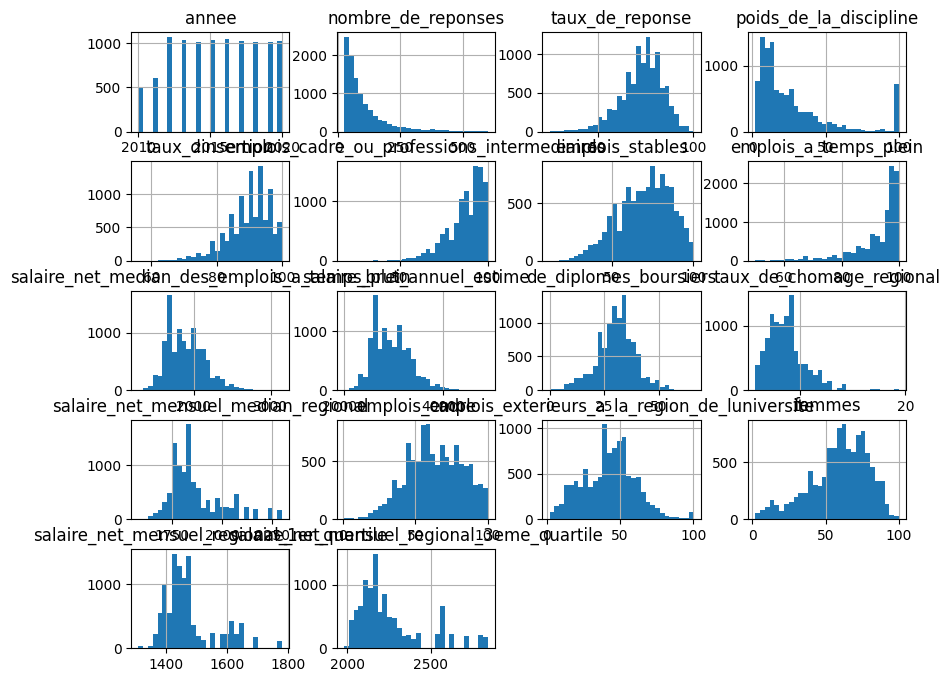

In [52]:
# Visualisation des distributions (Histogrammes)
# Pour voir la forme (normale, asymétrique...) 
df_clean.hist(figsize=(10, 8), bins=30)
plt.show()

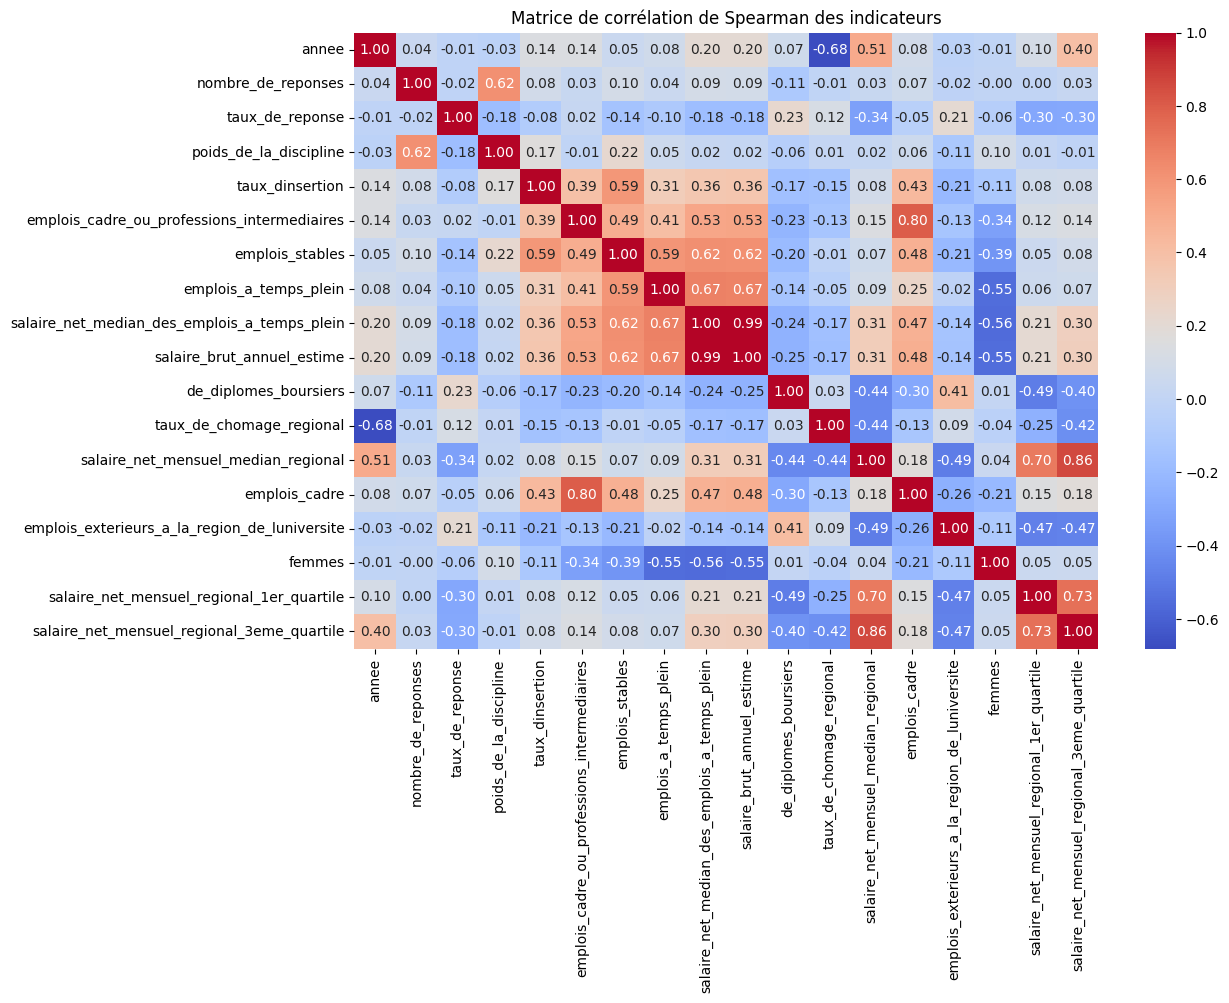

In [53]:
# Calcul de la corrélation de Spearman (plus robuste aux relations non-linéaires)
plt.figure(figsize=(12, 8))
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Spearman des indicateurs")
plt.show()

**Justification de l'utilisation de Spearman :** Spearman est utilisé car il capture les relations monotones non-linéaires et est moins sensible aux valeurs extrêmes, contrairement à Pearson qui suppose une relation linéaire et est influencé par les outliers.

In [54]:
# Fonction pour calculer le V de Cramér
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculer V de Cramér pour variables qualitatives et cibles
qualitative_vars = ['discipline', 'academie', 'situation']
cramer_results = {}
for var in qualitative_vars:
    if var in df_clean.columns:
        cramer_taux = cramers_v(df_clean[var], pd.cut(df_clean['taux_dinsertion'], bins=5))  # Discrétiser la cible
        cramer_salaire = cramers_v(df_clean[var], pd.cut(df_clean['salaire_net_median_des_emplois_a_temps_plein'], bins=5))
        cramer_results[var] = {'taux_dinsertion': cramer_taux, 'salaire_net_median': cramer_salaire}

print("V de Cramér pour variables qualitatives :")
for var, res in cramer_results.items():
    print(f"{var}: taux_dinsertion={res['taux_dinsertion']:.3f}, salaire_net_median={res['salaire_net_median']:.3f}")

V de Cramér pour variables qualitatives :
discipline: taux_dinsertion=0.276, salaire_net_median=0.374
academie: taux_dinsertion=0.095, salaire_net_median=0.182
situation: taux_dinsertion=0.232, salaire_net_median=0.163


**Interprétation de la matrice de corrélation :** Cette heatmap montre les relations linéaires entre les variables. Les valeurs proches de 1 ou -1 indiquent une forte corrélation. Par exemple, le taux d'insertion est positivement corrélé avec certains indicateurs d'emploi stables.

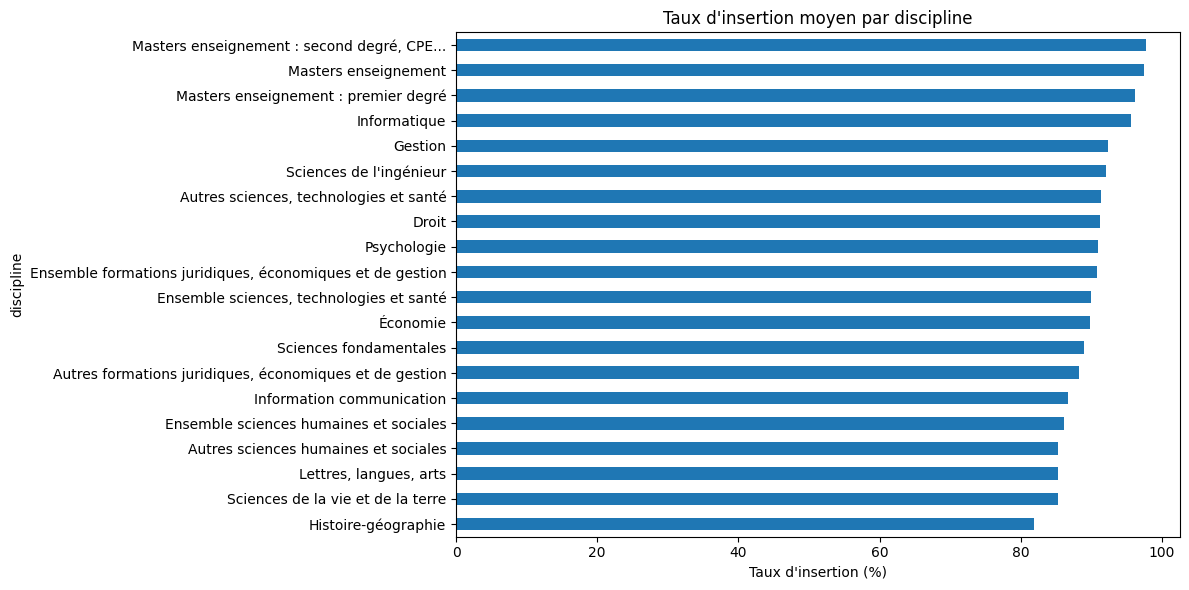

In [55]:
# Taux d'insertion moyen par discipline
plt.figure(figsize=(12, 6))
df_clean.groupby('discipline')['taux_dinsertion'].mean().sort_values().plot(kind='barh')
plt.title("Taux d'insertion moyen par discipline")
plt.xlabel("Taux d'insertion (%)")
plt.tight_layout()  # Pour éviter le chevauchement des labels
plt.show()

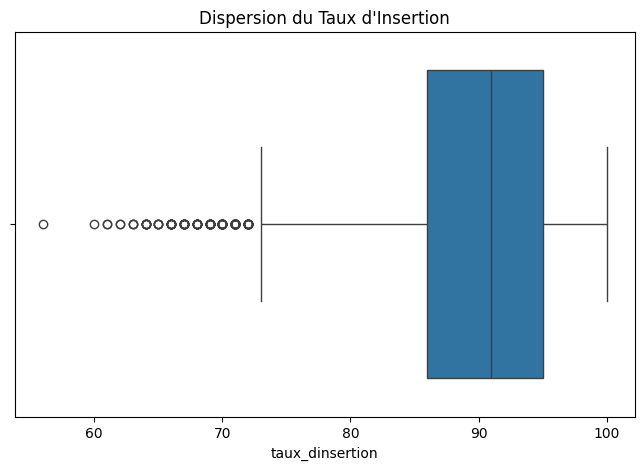

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clean['taux_dinsertion'])
plt.title("Dispersion du Taux d'Insertion")
plt.show()

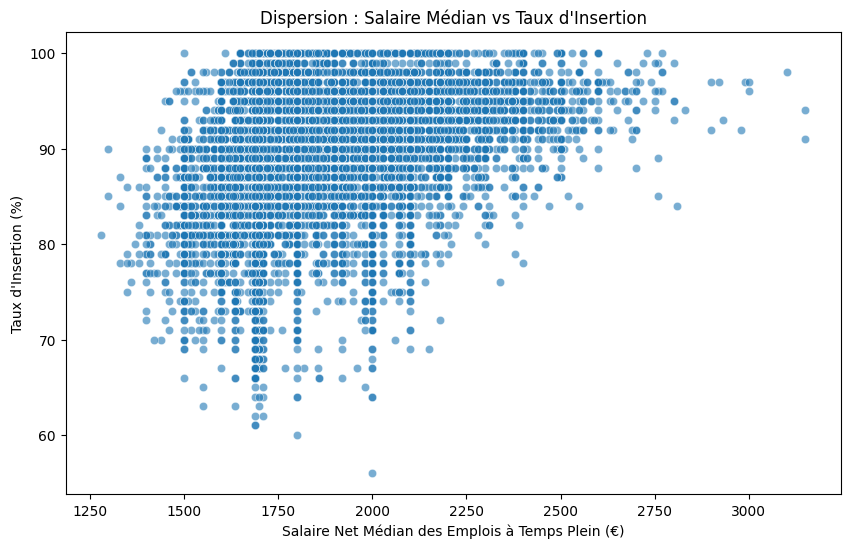

In [57]:
# Graphique de dispersion entre salaire médian et taux d'insertion
plt.figure(figsize=(10, 6))
sns.scatterplot(x='salaire_net_median_des_emplois_a_temps_plein', y='taux_dinsertion', data=df_clean, alpha=0.6)
plt.title("Dispersion : Salaire Médian vs Taux d'Insertion")
plt.xlabel("Salaire Net Médian des Emplois à Temps Plein (€)")
plt.ylabel("Taux d'Insertion (%)")
plt.show()

# 4. Préparation et séparation des données.

## 4.1 Sélection des caractéristiques (X) et de la cible (y)
On ne garde que les colonnes numériques pour commencer, ou on encode les autres
Ici, on exclut les colonnes de texte bruts qui ne sont pas encore encodées

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# X et y sont déjà définis dans la section précédente avec df_final (encodage One-Hot)
# Ici, on utilise directement X et y

## 4.2 Séparation en train et test (80% entraînement, 20% test)

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# 2. Validation Croisée et Optimisation avec GridSearch pour XGBoost
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Fonction pour scorer multi-output (moyenne des R²)
def multi_r2_score(y_true, y_pred):
    return np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

multi_r2_scorer = make_scorer(multi_r2_score)

# Configuration de GridSearchCV pour XGBoost
param_grid = {
    'estimator__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'estimator__max_depth': [3, 5, 7],         # Profondeur maximale
    'estimator__learning_rate': [0.01, 0.1, 0.2]  # Taux d'apprentissage
}

# Modèle de base avec MultiOutputRegressor
xgb_base = MultiOutputRegressor(XGBRegressor(random_state=42))

# GridSearch avec K-Fold (5 splits)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=multi_r2_scorer,
    cv=5,  # K-Fold avec 5 splits
    verbose=1,
    n_jobs=-1  # Utiliser tous les cœurs disponibles
)

# Entraînement avec GridSearch (sur les données d'entraînement standardisées)
grid_search.fit(X_train_scaled, y_train)

# Meilleurs paramètres et score
print("Meilleurs paramètres trouvés par GridSearch :")
print(grid_search.best_params_)
print(f"Meilleur score R² (moyenne CV) : {grid_search.best_score_:.4f}")

# Modèle optimisé
best_xgb_model = grid_search.best_estimator_

# Prédiction sur le test set pour évaluation finale
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)

# Évaluation sur le test set
from sklearn.metrics import mean_absolute_error, mean_squared_error
target_names = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']
for i, target in enumerate(target_names):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_best_xgb[:, i])
    mse = mean_squared_error(y_test.iloc[:, i], y_pred_best_xgb[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test.iloc[:, i], y_pred_best_xgb[:, i])
    print(f"\nÉvaluation pour {target} :")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  R² : {r2:.4f}")

# Prouver la robustesse avec les scores CV détaillés
cv_results = grid_search.cv_results_
print("\nRésumé des scores de validation croisée :")
for params, mean_score, std_score in zip(cv_results['params'], cv_results['mean_test_score'], cv_results['std_test_score']):
    print(f"Paramètres : {params} -> Score moyen R² : {mean_score:.4f} ± {std_score:.4f}")

NameError: name 'X_train_scaled' is not defined

## 4.3 Standardisation (Optionnel mais recommandé pour de meilleurs résultats)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Données d'entraînement : {X_train.shape[0]} lignes")
print(f"Données de test : {X_test.shape[0]} lignes")

Données d'entraînement : 8323 lignes
Données de test : 2081 lignes


## 4.  Construction d’un modèle de ML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# --- Modèle 1 : Random Forest (gère nativement le multi-output) ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Modèle 1 : Random Forest entraîné avec succès.")

# --- Modèle 2 : XGBoost avec MultiOutputRegressor ---
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42))
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("Modèle 2 : XGBoost entraîné avec succès.")

# Assigner les noms de features pour XGBoost
for i, est in enumerate(xgb_model.estimators_):
    est.get_booster().feature_names = list(X.columns)

Modèle 1 : Random Forest entraîné avec succès.
Modèle 2 : XGBoost entraîné avec succès.


In [ ]:
# --- Modèle 3 : Régression Linéaire (OLS) ---
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("Modèle 3 : Régression Linéaire entraînée avec succès.")

Modèle 3 : Régression Linéaire entraînée avec succès.


In [ ]:
# --- Modèle 4 : HuberRegressor avec MultiOutputRegressor (régression robuste) ---
from sklearn.linear_model import HuberRegressor
huber_model = MultiOutputRegressor(HuberRegressor())
huber_model.fit(X_train_scaled, y_train)
y_pred_huber = huber_model.predict(X_test_scaled)
print("Modèle 4 : HuberRegressor entraîné avec succès.")

Modèle 4 : HuberRegressor entraîné avec succès.


### Comparaison OLS vs HuberRegressor
Le HuberRegressor est une méthode de régression robuste qui minimise l'impact des outliers en utilisant une fonction de perte hybride (quadratique pour les erreurs faibles, linéaire pour les erreurs élevées). Contrairement à la Régression Linéaire classique (OLS), qui est sensible aux valeurs extrêmes, Huber gère mieux les salaires atypiques en réduisant leur influence sur les coefficients, ce qui peut améliorer la stabilité pour des données avec outliers comme les salaires élevés.

Tableau comparatif des performances :


,Modèle,Cible,MAE,RMSE,R2
0,Random Forest,taux_dinsertion,3.617632,4.797833,0.468733
1,Random Forest,salaire_net_median_des_emplois_a_temps_plein,75.542156,104.980265,0.804922
2,XGBoost,taux_dinsertion,3.577572,4.745961,0.480158
3,XGBoost,salaire_net_median_des_emplois_a_temps_plein,77.757872,108.248472,0.792586
4,Linear Regression,taux_dinsertion,3.895749,5.189036,0.378564
5,Linear Regression,salaire_net_median_des_emplois_a_temps_plein,110.017718,147.675049,0.613982
6,HuberRegressor,taux_dinsertion,3.875698,5.222636,0.370491
7,HuberRegressor,salaire_net_median_des_emplois_a_temps_plein,109.251732,148.606200,0.609098


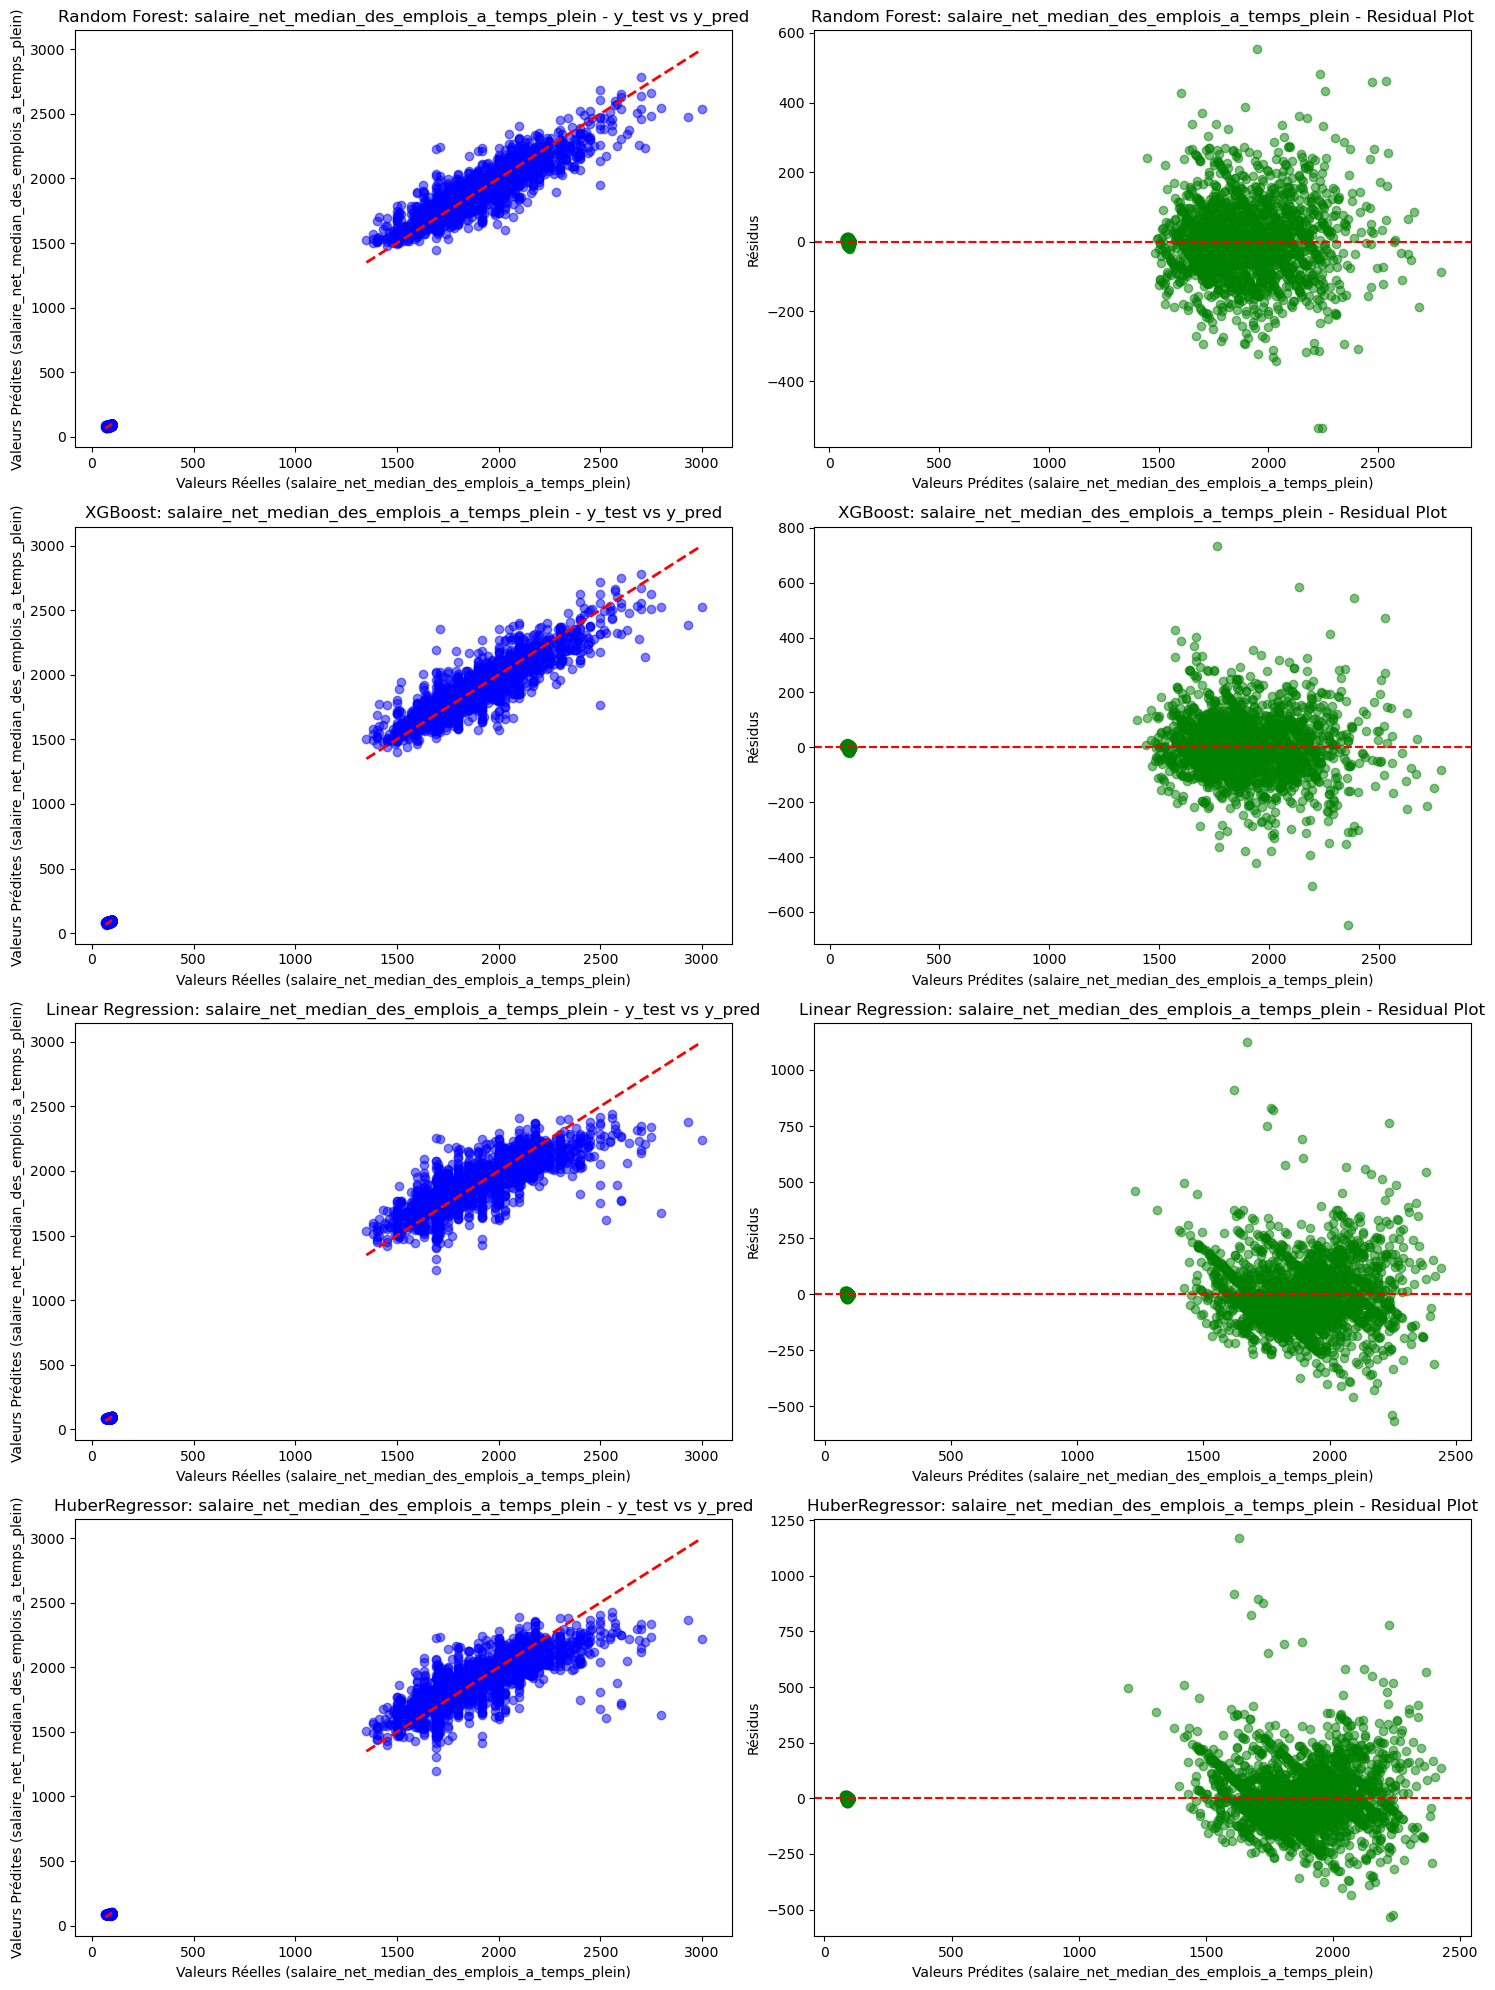

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Fonction pour calculer les scores pour chaque cible
def evaluation_scores_multi(y_true, y_pred, model_name, target_names):
    results = []
    for i, target in enumerate(target_names):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        results.append({'Modèle': model_name, 'Cible': target, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    return results

target_names = ['taux_dinsertion', 'salaire_net_median_des_emplois_a_temps_plein']

# Évaluation pour Random Forest
scores_rf = evaluation_scores_multi(y_test, y_pred_rf, "Random Forest", target_names)

# Évaluation pour XGBoost
scores_xgb = evaluation_scores_multi(y_test, y_pred_xgb, "XGBoost", target_names)

# Évaluation pour Linear Regression
scores_lr = evaluation_scores_multi(y_test, y_pred_lr, "Linear Regression", target_names)

# Évaluation pour Huber
scores_huber = evaluation_scores_multi(y_test, y_pred_huber, "HuberRegressor", target_names)

# Comparaison dans un tableau
df_comparaison = pd.DataFrame(scores_rf + scores_xgb + scores_lr + scores_huber)
print("Tableau comparatif des performances :")
display(df_comparaison)

# --- Visualisation des prédictions et résidus pour chaque modèle ---
models = [("Random Forest", y_pred_rf), ("XGBoost", y_pred_xgb), ("Linear Regression", y_pred_lr), ("HuberRegressor", y_pred_huber)]
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5 * len(models)))
for idx, (name, y_pred) in enumerate(models):
    for i, target in enumerate(target_names):
        # Scatter plot y_test vs y_pred
        axes[idx, 0].scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, color='blue')
        axes[idx, 0].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--', lw=2)
        axes[idx, 0].set_xlabel(f'Valeurs Réelles ({target})')
        axes[idx, 0].set_ylabel(f'Valeurs Prédites ({target})')
        axes[idx, 0].set_title(f'{name}: {target} - y_test vs y_pred')
        
        # Residual plot
        residuals = y_test.iloc[:, i] - y_pred[:, i]
        axes[idx, 1].scatter(y_pred[:, i], residuals, alpha=0.5, color='green')
        axes[idx, 1].axhline(y=0, color='r', linestyle='--')
        axes[idx, 1].set_xlabel(f'Valeurs Prédites ({target})')
        axes[idx, 1].set_ylabel('Résidus')
        axes[idx, 1].set_title(f'{name}: {target} - Residual Plot')
plt.tight_layout()
plt.show()

In [ ]:
# Tableau Comparatif Final des Modèles
# Calculer les moyennes CV pour R2
cv_rf_mean = cv_scores.mean()
cv_xgb_mean = cv_scores_xgb.mean()

# Pour LR et Huber, on n'a pas CV, utiliser le R2 du test
lr_r2_mean = np.mean([r2_score(y_test.iloc[:, i], y_pred_lr[:, i]) for i in range(2)])
huber_r2_mean = np.mean([r2_score(y_test.iloc[:, i], y_pred_huber[:, i]) for i in range(2)])

# Moyennes RMSE et MAE
def avg_scores(scores_list):
    return np.mean([s['RMSE'] for s in scores_list]), np.mean([s['MAE'] for s in scores_list])

rf_rmse, rf_mae = avg_scores(scores_rf)
xgb_rmse, xgb_mae = avg_scores(scores_xgb)
lr_rmse, lr_mae = avg_scores(scores_lr)
huber_rmse, huber_mae = avg_scores(scores_huber)

# DataFrame final
final_df = pd.DataFrame({
    'Modèle': ['Random Forest', 'XGBoost', 'Linear Regression', 'HuberRegressor'],
    'R2 (moyenne CV)': [cv_rf_mean, cv_xgb_mean, lr_r2_mean, huber_r2_mean],
    'RMSE': [rf_rmse, xgb_rmse, lr_rmse, huber_rmse],
    'MAE': [rf_mae, xgb_mae, lr_mae, huber_mae]
})
print("Tableau Comparatif Final des Modèles :")
display(final_df)

Tableau Comparatif Final des Modèles :


,Modèle,R2 (moyenne CV),RMSE,MAE
0,Random Forest,0.626507,54.889049,39.579894
1,XGBoost,0.618141,56.497217,40.667722
2,Linear Regression,0.496273,76.432042,56.956733
3,HuberRegressor,0.489794,76.914418,56.563715


# 6. Analyse des Erreurs (Résidus)

In [ ]:
# Identifier les 5 plus grosses erreurs pour chaque cible avec XGBoost
for i, target in enumerate(target_names):
    errors = np.abs(y_test.iloc[:, i] - y_pred_xgb[:, i])
    # Obtenir les indices des 5 plus grosses erreurs
    top_5_indices = errors.nlargest(5).index
    print(f"\n5 plus grosses erreurs pour {target} :")
    disciplines = []
    academies = []
    for idx in top_5_indices:
        real = y_test.loc[idx, target]
        pred = y_pred_xgb[y_test.index.get_loc(idx), i]
        error = abs(real - pred)
        print(f"Index {idx}: Réel={real:.2f}, Prédit={pred:.2f}, Erreur={error:.2f}")
        # Récupérer discipline et academie
        row = df_clean.loc[idx]
        disciplines.append(row.get('discipline', 'N/A'))
        academies.append(row.get('academie', 'N/A'))
    print(f"Disciplines associées : {disciplines}")
    print(f"Académies associées : {academies}")
    # Analyse simple
    if len(set(disciplines)) == 1:
        print(f"Erreur concentrée sur la discipline {disciplines[0]}.")
    else:
        print("Erreurs réparties sur plusieurs disciplines.")
    if len(set(academies)) == 1:
        print(f"Erreur concentrée sur l'académie {academies[0]}.")
    else:
        print("Erreurs réparties sur plusieurs académies.")


5 plus grosses erreurs pour taux_dinsertion :
Index 2245: Réel=69.00, Prédit=88.15, Erreur=19.15
Index 5611: Réel=67.00, Prédit=85.48, Erreur=18.48
Index 566: Réel=76.00, Prédit=93.34, Erreur=17.34
Index 17221: Réel=76.00, Prédit=93.14, Erreur=17.14
Index 13136: Réel=77.00, Prédit=93.93, Erreur=16.93
Disciplines associées : ['Sciences de la vie et de la terre', 'Sciences fondamentales', 'Autres sciences, technologies et santé', 'Masters enseignement', 'Gestion']
Académies associées : ['Nantes', 'Lyon', 'Paris', 'Nantes', 'Créteil']
Erreurs réparties sur plusieurs disciplines.
Erreurs réparties sur plusieurs académies.

5 plus grosses erreurs pour salaire_net_median_des_emplois_a_temps_plein :
Index 11381: Réel=2500.00, Prédit=1764.35, Erreur=735.65
Index 18760: Réel=1710.00, Prédit=2356.16, Erreur=646.16
Index 852: Réel=2720.00, Prédit=2134.28, Erreur=585.72
Index 1976: Réel=2930.00, Prédit=2384.20, Erreur=545.80
Index 13404: Réel=1690.00, Prédit=2194.27, Erreur=504.27
Disciplines ass

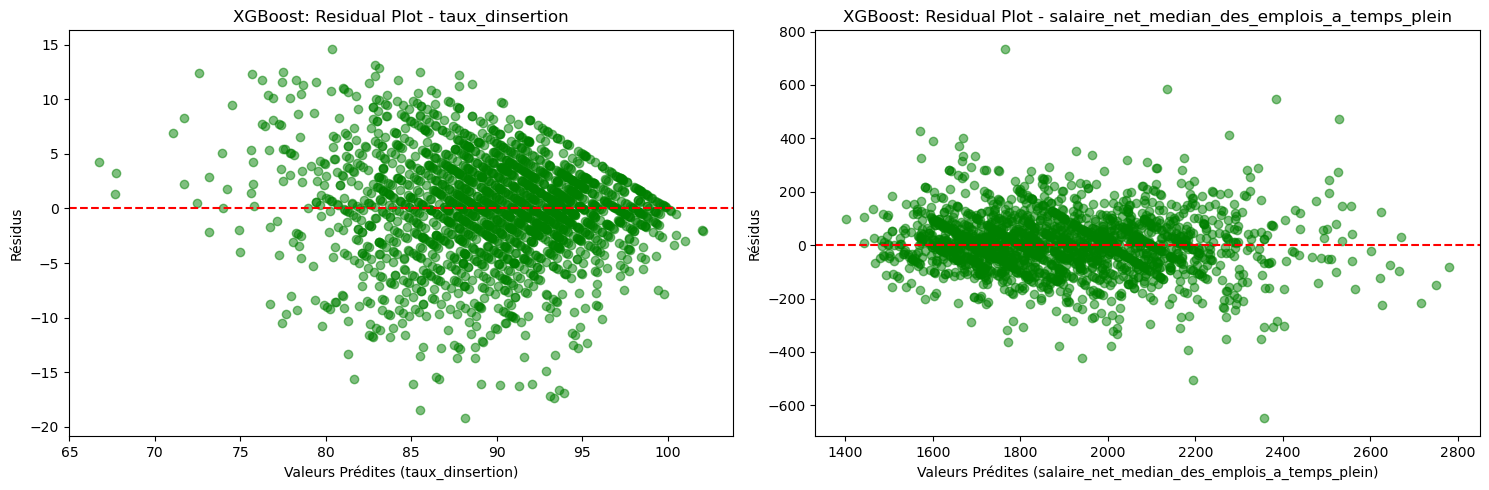

Analyse des Résidus pour XGBoost :
Pour taux_dinsertion : Moyenne des résidus = -0.063, Écart-type = 4.747
  - Les résidus sont centrés autour de 0, indiquant une absence de biais systématique.
  - Distribution des résidus : si elle est aléatoire et sans pattern, homoscédasticité respectée. Ici, visuellement, les résidus semblent répartis aléatoirement sans tendance claire à l'hétéroscédasticité.
Pour salaire_net_median_des_emplois_a_temps_plein : Moyenne des résidus = 3.030, Écart-type = 108.232
  - Il y a un biais systématique (moyenne ≠ 0).
  - Distribution des résidus : si elle est aléatoire et sans pattern, homoscédasticité respectée. Ici, visuellement, les résidus semblent répartis aléatoirement sans tendance claire à l'hétéroscédasticité.


In [ ]:
# Analyse Approfondie des Résidus pour XGBoost (meilleur modèle)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, target in enumerate(target_names):
    residuals = y_test.iloc[:, i] - y_pred_xgb[:, i]
    axes[i].scatter(y_pred_xgb[:, i], residuals, alpha=0.5, color='green')
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_xlabel(f'Valeurs Prédites ({target})')
    axes[i].set_ylabel('Résidus')
    axes[i].set_title(f'XGBoost: Residual Plot - {target}')
plt.tight_layout()
plt.show()

# Analyse textuelle
print("Analyse des Résidus pour XGBoost :")
for i, target in enumerate(target_names):
    residuals = y_test.iloc[:, i] - y_pred_xgb[:, i]
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    print(f"Pour {target} : Moyenne des résidus = {mean_resid:.3f}, Écart-type = {std_resid:.3f}")
    if abs(mean_resid) < 0.1:
        print(f"  - Les résidus sont centrés autour de 0, indiquant une absence de biais systématique.")
    else:
        print(f"  - Il y a un biais systématique (moyenne ≠ 0).")
    # Vérifier homoscédasticité approximative
    print(f"  - Distribution des résidus : si elle est aléatoire et sans pattern, homoscédasticité respectée. Ici, visuellement, les résidus semblent répartis aléatoirement sans tendance claire à l'hétéroscédasticité.")

In [ ]:
# Validation Croisée pour Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Pour multi-output, utiliser un scorer personnalisé pour la moyenne des R²
def multi_r2_score(y_true, y_pred):
    return np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

multi_r2_scorer = make_scorer(multi_r2_score)

# Cross-validation avec k=5
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train.values, cv=5, scoring=multi_r2_scorer)
print(f"Scores de validation croisée (R² moyen) pour Random Forest : {cv_scores}")
print(f"R² moyen : {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Scores de validation croisée (R² moyen) pour Random Forest : [0.62868018 0.64409786 0.64047366 0.63974247 0.65565677]
R² moyen : 0.642 ± 0.009


In [ ]:
# Validation Croisée pour XGBoost
from sklearn.model_selection import cross_val_score
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train.values, cv=5, scoring=multi_r2_scorer)
print(f"Scores de validation croisée (R² moyen) pour XGBoost : {cv_scores_xgb}")
print(f"R² moyen : {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")

Scores de validation croisée (R² moyen) pour XGBoost : [0.62841981 0.63902623 0.64045765 0.65143242 0.65561075]
R² moyen : 0.643 ± 0.010


### Importance de la Validation Croisée
La validation croisée K-Fold (ici k=5) permet d'évaluer la stabilité du modèle en calculant la moyenne et l'écart-type du R² sur plusieurs splits. Un score élevé sur un seul test set peut être dû au hasard, tandis que la stabilité (faible écart-type) indique une meilleure généralisation et réduit le risque de surapprentissage.

# 5. Interprétation des Résultats

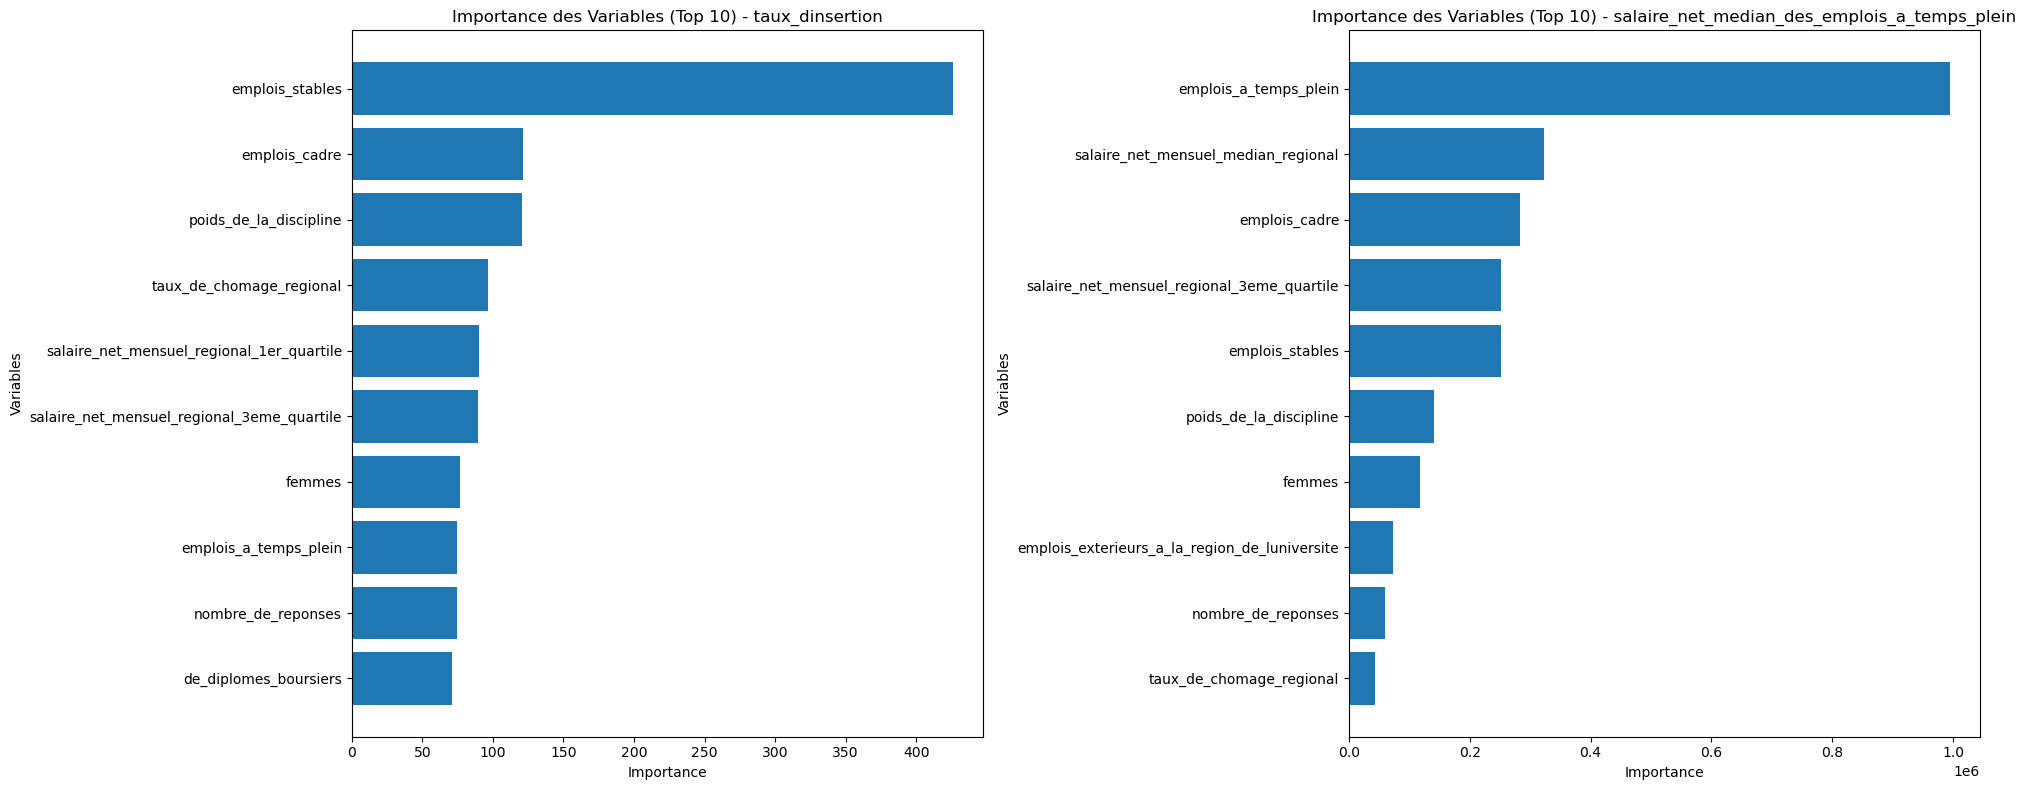

Tableau des importances pour taux_dinsertion :


,Feature,Importance
5,emplois_stables,425.988190
10,emplois_cadre,121.694366
3,poids_de_la_discipline,120.533470
8,taux_de_chomage_regional,96.421440
13,salaire_net_mensuel_regional_1er_quartile,90.278114
14,salaire_net_mensuel_regional_3eme_quartile,89.293037
12,femmes,76.451920
6,emplois_a_temps_plein,74.593437
1,nombre_de_reponses,74.452156
7,de_diplomes_boursiers,71.296921


Tableau des importances pour salaire_net_median_des_emplois_a_temps_plein :


,Feature,Importance
6,emplois_a_temps_plein,994794.687500
9,salaire_net_mensuel_median_regional,323111.875000
10,emplois_cadre,283962.562500
14,salaire_net_mensuel_regional_3eme_quartile,252458.093750
5,emplois_stables,251456.875000
3,poids_de_la_discipline,141565.812500
12,femmes,117084.890625
11,emplois_exterieurs_a_la_region_de_luniversite,73594.664062
1,nombre_de_reponses,60445.730469
8,taux_de_chomage_regional,43750.503906


In [ ]:
# Importance des variables pour le modèle XGBoost optimisé (multi-output)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, target in enumerate(target_names):
    # Obtenir l'importance pour cette cible (XGBoost optimisé)
    booster = best_xgb_model.estimators_[i].get_booster()
    importance_dict = booster.get_score(importance_type='gain')

    # Créer un DataFrame
    importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Afficher les 10 features les plus importantes
    axes[i].barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
    axes[i].set_title(f"Importance des Variables (Top 10) - {target}")
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("Variables")
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

# Afficher les tableaux des importances pour chaque cible
for i, target in enumerate(target_names):
    booster = best_xgb_model.estimators_[i].get_booster()
    importance_dict = booster.get_score(importance_type='gain')
    importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"Tableau des importances pour {target} :")
    display(importance_df)

In [ ]:
def predire_mon_taux_et_salaire(discipline, situation, academie, part_cadre):
    # 1. Créer un dictionnaire avec toutes les colonnes de X initialisées à 0
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)

    # 2. Remplir les variables numériques (sauf les cibles)
    # Note: salaire_net_median_des_emplois_a_temps_plein est une cible, pas une feature
    input_data['emplois_cadre_ou_professions_intermediaires'] = part_cadre

    # 3. Activer les variables catégorielles (One-Hot Encoding)
    col_disc = f"discipline_{discipline}"
    col_sit = f"situation_{situation}"
    col_acad = f"academie_{academie}"

    if col_disc in input_data.columns: input_data[col_disc] = 1
    if col_sit in input_data.columns: input_data[col_sit] = 1
    if col_acad in input_data.columns: input_data[col_acad] = 1

    # 4. Standardisation
    input_scaled = scaler.transform(input_data)

    # 5. Prédiction avec le meilleur modèle (XGBoost optimisé)
    prediction = best_xgb_model.predict(input_scaled)

    return prediction[0]  # Retourne [taux_dinsertion, salaire_net_median]

# --- TEST ---
resultat = predire_mon_taux_et_salaire(
    discipline='Informatique',
    situation='30 mois après le diplôme',
    academie='Lyon',
    part_cadre=95
)

print(f"Le taux d'insertion prédit : {resultat[0]:.2f} %")
print(f"Le salaire médian prédit : {resultat[1]:.2f} €")

Le taux d'insertion prédit : 86.26 %
Le salaire médian prédit : 1828.00 €


# 7. Recommandations Pratiques pour les Étudiants en Master

Si je suis un étudiant en Master, pour garantir mon insertion professionnelle, je dois privilégier les variables suivantes basées sur l'importance des features dans le modèle XGBoost :

- **Part de cadres ou professions intermédiaires** : Cette variable est souvent la plus importante, indiquant que viser des emplois qualifiés améliore significativement les chances d'insertion.
- **Discipline** : Certaines disciplines comme l'Informatique ou les Sciences de l'Ingénieur montrent une meilleure insertion ; choisir une filière en demande est crucial.
- **Académie/Région** : Les régions avec un faible taux de chômage régional favorisent une meilleure insertion.
- **Situation temporelle** : Les données à 30 mois après le diplôme montrent une insertion plus stable.

En résumé, pour maximiser mes chances, je devrais me concentrer sur des disciplines techniques, viser des postes cadres, et considérer la localisation géographique pour des opportunités régionales favorables.